In [548]:
import numpy as np
# import scanpy.api as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
# import gseapy

from ete3 import Tree
import networkx as nx

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook
from tqdm import tqdm

import utilities.metastasis_score_utils as met_utils
# from cassiopeia.TreeSolver import data_pipeline
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
import cassiopeia.TreeSolver.post_process_tree as ppt

from ipywidgets import IntProgress
from cassiopeia.TreeSolver import utilities as util

#from fitch_parsimony import *

#from Cassiopeia.TreeSolver import data_pipeline
import cassiopeia.TreeSolver.compute_meta_purity as cmp


In [577]:
dfAT = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/ALL.5k.FINISHED.alleleTable.txt", sep='\t')
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

## Compute basic statistics

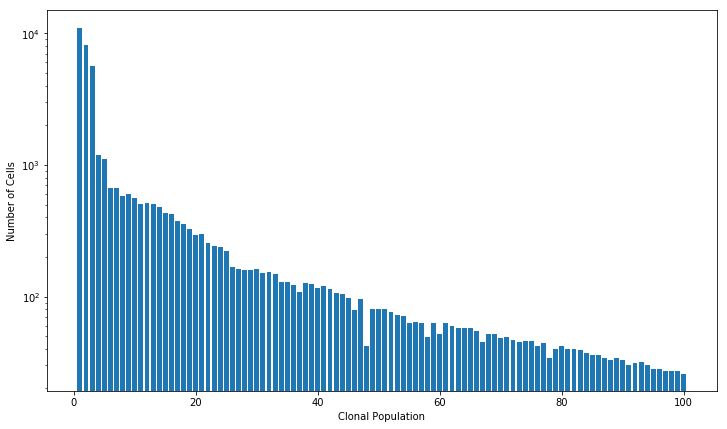

In [578]:
lg_sizes = dfAT.groupby("LineageGroup").agg({"cellBC": 'nunique'})

h = plt.figure(figsize=(12,7))
plt.bar(lg_sizes.index, lg_sizes['cellBC'])
plt.yscale('log')
plt.xlabel("Clonal Population")
plt.ylabel("Number of Cells")
#plt.savefig('figs/10k_lg_sizes.png')
plt.show()

lg_sizes = lg_sizes['cellBC'].to_dict()

<Figure size 504x1080 with 0 Axes>

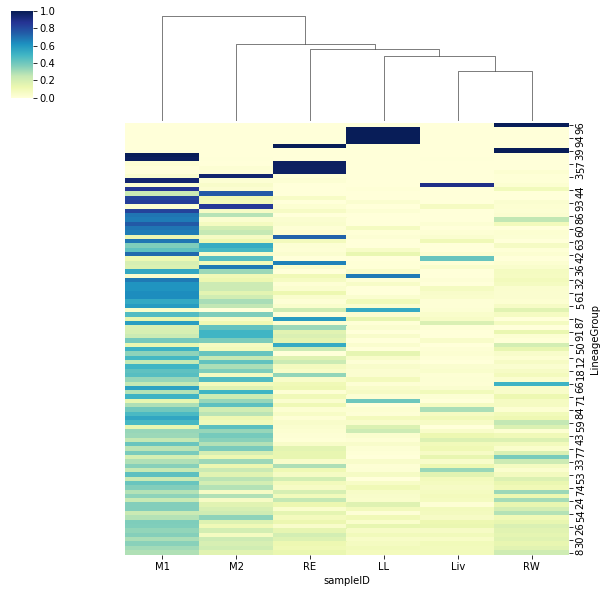

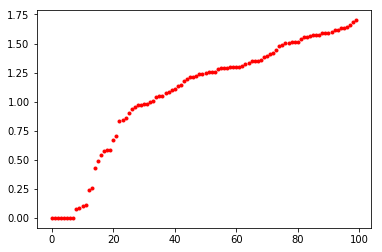

In [580]:
meta['BC'] = meta.index
samp_piv = pd.pivot_table(meta, index='LineageGroup', columns = 'sampleID', values = 'BC', aggfunc='count')

samp_piv.fillna(0, inplace=True)
samp_piv = samp_piv.apply(lambda x: x / x.sum(), axis=1)

entropy = samp_piv.apply(lambda x: -1*np.sum([p * np.log(p) for p in x.values if p > 0]), axis=1)
inds_order = entropy.sort_values().index

h = plt.figure(figsize = (7,15))
sns.clustermap(samp_piv.loc[inds_order], row_cluster=False, cmap='YlGnBu')
# plt.savefig("figs/lg_sample_dist.png")
plt.show()

plt.plot(range(len(entropy)), entropy.sort_values(), 'r.')
# plt.savefig("figs/10k_lg_entropy.png")
plt.show()

## First perform filtering

In [581]:

dfAT_rtot = dfAT.groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r.tot'})
dfAT_r1unc = dfAT[dfAT['r1.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r1.uncut'})
dfAT_r2unc = dfAT[dfAT['r2.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r2.old":'count'}).rename(index=str, columns={'r2.old':'r2.uncut'})
dfAT_r3unc = dfAT[dfAT['r3.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r3.old":'count'}).rename(index=str, columns={'r3.old':'r3.uncut'})

dfCUT = pd.concat([dfAT_rtot,dfAT_r1unc,dfAT_r2unc,dfAT_r3unc], axis=1)
dfCUT = dfCUT.fillna(0)
dfCUT = dfCUT.sort_values("LineageGroup")

dfCUT['r1.cut%'] = 1-(dfCUT['r1.uncut']/dfCUT['r.tot'])
dfCUT['r2.cut%'] = 1-(dfCUT['r2.uncut']/dfCUT['r.tot'])
dfCUT['r3.cut%'] = 1-(dfCUT['r3.uncut']/dfCUT['r.tot'])

dfCUT['cut%'] = (dfCUT['r1.cut%']+dfCUT['r2.cut%']+dfCUT['r3.cut%'])/3

X1 = dfCUT.groupby(['LineageGroup']).agg({'r1.cut%':'mean'})
X2 = dfCUT.groupby(['LineageGroup']).agg({'r2.cut%':'mean'})
X3 = dfCUT.groupby(['LineageGroup']).agg({'r3.cut%':'mean'})

XCUT = pd.concat([X1,X2,X3], axis=1).reset_index()
XCUT.LineageGroup = pd.to_numeric(XCUT.LineageGroup, errors='coerce')
XCUT = XCUT.sort_values("LineageGroup").set_index("LineageGroup")

cut_rates = XCUT.sum(1)/3

# cut_rates.to_csv("data/cutRateByLG.10k.txt", sep='\t')

In [582]:
cut_rates

LineageGroup
1      0.748344
2      0.705712
3      0.511629
4      0.713669
5      0.136506
6      0.558497
7      0.263347
8      0.769389
9      0.618165
10     0.472420
11     0.422479
12     0.717509
13     0.728639
14     0.731674
15     0.445716
16     0.067490
17     0.437772
18     0.024539
19     0.402322
20     0.475744
21     0.671614
22     0.399308
23     0.559197
24     0.899406
25     0.059993
26     0.880342
27     0.364800
28     0.792744
29     0.507301
30     0.914160
         ...   
71     0.287296
72     0.530657
73     0.400088
74     0.283386
75     0.113371
76     0.368261
77     0.657828
78     0.573708
79     0.671776
80     0.574846
81     0.016316
82     0.731002
83     0.835585
84     0.699228
85     0.882887
86     0.668981
87     0.116529
88     0.941077
89     0.874094
90     0.597363
91     0.649376
92     0.678552
93     0.906076
94     0.542870
95     0.470172
96     0.529186
97     0.572063
98     0.830394
99     0.632520
100    0.666204
Length: 100

In [ ]:
# cut_rates = pd.read_csv("data/cutRateByLG.5k.txt", sep='\t', header=None, index_col = 0)

labels = []
tree_fps = []
# lg_to_nj = {}
lg_to_hyb = {}
lg_to_cm = {}
i = 0
for tree_dir in tqdm(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    hyb_fps = [fp for fp in os.listdir(tree_dir) if 'hybrid_priors.alleleThresh.processed.pkl' in fp]
    # nj_fps = [fp for fp in os.listdir(tree_dir) if "nj_priorsalleleThresh.pkl" in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.alleleThresh.txt" in fp]
    if len(hyb_fps) > 0:
            try:
                cmfp = tree_dir + cmfp[0]
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
                lg_to_cm[int(lg)] = cm

                hyb = nx.read_gpickle(tree_dir + hyb_fps[0])
                lg_to_hyb[int(lg)] = hyb
                
                #nj = nx.read_gpickle(tree_dir + nj_fps[0])
                #lg_to_nj[int(lg)] = nj.post_process(cm)
                
                tree_fps.append(tree_dir + hyb_fps[0])
                
                labels.append(int(lg))
                
            except:
                print('error: ', lg, hyb_fps, nj_fps)
                i += 1
            #tree = Cassiopeia_Tree('from_newick', network = data_pipeline.newick_to_network(tree_dir + fps[0], cm))
            #lg_to_tree[int(lg)] = tree.post_process(cm)
    else:
        print("can't find tree: ", lg)
        
print(i)    

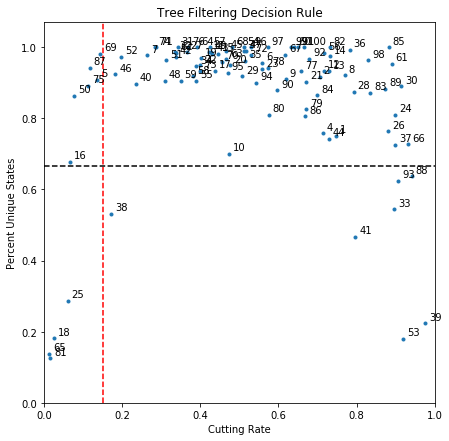

{65, 33, 5, 69, 39, 38, 41, 75, 16, 81, 18, 50, 53, 87, 88, 25, 93} 17


In [585]:
complexities = []
crs = []
num_leaves = []
num_nodes = []
uniq_states = []

all_depths = {}
mean_depths = []
max_depths = []

def assign_edge_lengths(tree):

    for e in tree.edges():

        tree[e[0]][e[1]]['length'] = 1 if e[0].get_mut_length(e[1]) > 0 else 0
    return tree


def set_depth(tree):
    
    tree= assign_edge_lengths(tree)
    
    root = [n for n in tree if tree.in_degree(n) == 0][0]
    
    depth = nx.shortest_path_length(tree, root, weight = 'length')
    for d in depth.keys():
        tree.nodes[d]["depth"] = depth[d]
        
    return tree
        
for lg in lg_to_hyb.keys():
    crs.append(cut_rates.loc[lg])
    tree_complexity = met_utils.compute_tree_complexity(lg_to_hyb[lg].network)
    complexities.append(tree_complexity[0])
    num_leaves.append(tree_complexity[1])
    num_nodes.append(tree_complexity[2])
    uniq_states.append(lg_to_cm[lg].drop_duplicates().shape[0] / lg_to_cm[lg].shape[0])
    
    tree = lg_to_hyb[lg].network
    tree = set_depth(tree)
           
    depths = [tree.nodes[n]['depth'] for n in tree if tree.out_degree(n) == 0]
    all_depths[lg] = depths
    mean_depths.append(np.mean(depths))
    max_depths.append(np.max(depths))
    
    
tree_stats = pd.DataFrame(index = lg_to_hyb.keys(), columns = ["CutRate", "TreeComplexity"])
tree_stats["CutRate"] = crs
tree_stats["TreeComplexity"] = complexities
tree_stats["NumLeaves"] = num_leaves
tree_stats["NumNodes"] = num_nodes
tree_stats['UniqStates'] = uniq_states
tree_stats['MeanDepth'] = mean_depths
tree_stats['MaxDepth'] = max_depths

to_drop = list(tree_stats[(tree_stats["CutRate"] < 0.15)].index)
to_drop += list(tree_stats[tree_stats["UniqStates"] < 0.667].index)

tree_stats['Filtered'] = False
tree_stats.loc[to_drop, 'Filtered'] = True


h = plt.figure(figsize=(7,7))
plt.plot(tree_stats["CutRate"], tree_stats["UniqStates"], '.')
plt.axvline(x = 0.15, color="red", linestyle="dashed")
plt.axhline(y = 0.667, color="black", linestyle="dashed")
plt.xlabel("Cutting Rate")
plt.ylabel("Percent Unique States")
plt.title("Tree Filtering Decision Rule")

for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CutRate"]+0.01, tree_stats.loc[i, "UniqStates"] + 0.01))

plt.ylim(0, 1.07)
plt.xlim(0, 1)
plt.show()


print(set(to_drop), len(set(to_drop)))

In [586]:
_depths = []
for lg in all_depths.keys():
    if lg in to_drop:
        continue
        
    _depths += all_depths[lg]

print(np.mean(_depths), np.mean(tree_stats.loc[np.setdiff1d(tree_stats.index.values, to_drop), 'MeanDepth']), np.max(tree_stats.loc[np.setdiff1d(tree_stats.index.values, to_drop), 'MaxDepth']))

7.254235946159937 6.190730828936103 20


# Infer metastatic abilities

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/data/yosef2/users/mattjones/projects/metastasis/MetastasisTracing/utilities/metastasis_score_utils.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  table = pd.concat([background, query], axis=1)


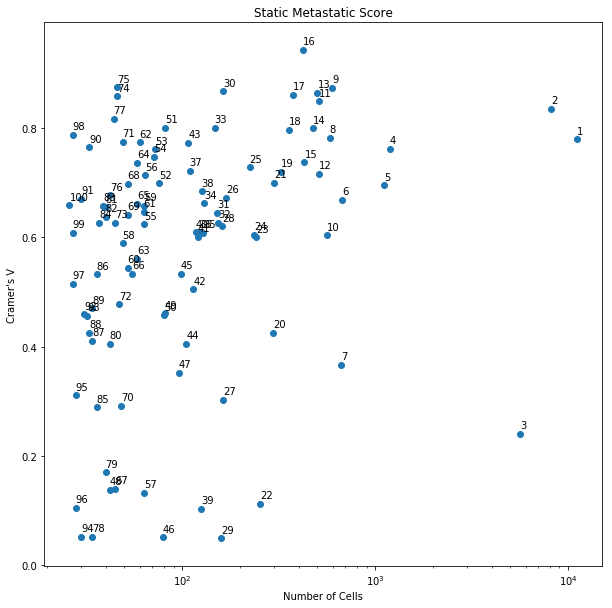

In [587]:
background = {}
for n, g in meta.groupby("sampleID"):
    background[n] = g.shape[0]
    
background = pd.DataFrame.from_dict(background, orient="index")

static_stats = {}
for n, g in tqdm_notebook(meta.groupby(["LineageGroup"])):

#     if n in to_drop:
#         continue
    
    stats = met_utils.compute_static_metastasis_score(g, background,  group_var = 'sampleID')
    
    static_stats[n] = tuple(stats)
    
colormap = ["blue"] * len(static_stats)
# colormap[0] = "red"
# colormap[1] = "green"
# colormap[3] = "black"
# colormap[5] = 'orange'
# colormap[35] = "black"

sizes = dict(zip(static_stats.keys(), list(map(lambda x: x[0], static_stats.values()))))
ss = dict(zip(static_stats.keys(), list(map(lambda x: 1 - x[3], static_stats.values()))))
labs = static_stats.keys()
# labs = [0, 1, 3, 5, 35]

h = plt.figure(figsize = (10, 10))
plt.scatter(sizes.values(), ss.values())
plt.xscale('log')
plt.xlabel("Number of Cells")
plt.ylabel("Cramer's V")
plt.title("Static Metastatic Score")

for i in labs:
   plt.annotate(i, (sizes[i]+0.05, ss[i]+0.01))

# plt.savefig("figs/static_met_score.pdf")
plt.show()

## Compute the dynamic metastatic score

In [ ]:
evolving_scores = {}
nj_evolving_scores = {}
nn_scores = {}
lg_to_fitch = {}

for n in tqdm(labels):

    # if n not in to_drop:
    # nj = lg_to_nj[n].network
    hyb = lg_to_hyb[n].network

    evolving_scores[n] = met_utils.compute_dynamic_metastasis_score(hyb, meta['sampleID'])
    # nj_evolving_scores[n] = met_utils.compute_dynamic_metastasis_score(nj, meta['sampleID'])
    nj_evolving_scores[n] = np.nan
    nn_scores[n] = met_utils.compute_NN_metastasis_score(hyb, meta['sampleID'], _method = 'allele', verbose=False)

    
    






  0%|          | 0/4 [00:00<?, ?it/s]





Creating pairs to compare: 100%|██████████| 150/150 [00:00<00:00, 13617.28it/s][A





 25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]





Creating pairs to compare: 100%|██████████| 467/467 [00:00<00:00, 7185.40it/s]





 50%|█████     | 2/4 [00:01<00:01,  1.40it/s]





Creating pairs to compare: 100%|██████████| 497/497 [00:00<00:00, 7715.97it/s]





 75%|███████▌  | 3/4 [00:03<00:00,  1.12it/s]





Creating pairs to compare:   0%|          | 0/17104 [00:00<?, ?it/s]





Creating pairs to compare:   0%|          | 6/17104 [00:00<05:04, 56.19it/s]





Creating pairs to compare:   0%|          | 8/17104 [00:26<18:56:09,  3.99s/it]





Creating pairs to compare:   0%|          | 17/17104 [00:26<13:15:50,  2.79s/it]





Creating pairs to compare:   0%|          | 27/17104 [00:26<9:17:39,  1.96s/it] 





Creating pairs to compare:   0%|          | 32/17104 [00:27<6:43:05,  1.42s/it]





Creating pairs to compare:   0%|          | 42

In [ ]:
met_scores = pd.DataFrame([ss, es]).T
met_scores.index = evolving_scores.keys()
met_scores.columns = ["TissueDispersion", "TreeMetRate"]
met_scores['AlleleMetRate'] = met_scores.apply(lambda x: nn_scores[x.name] if x.name in nn_scores.keys() else None, axis=1)
met_scores['TreeMetRate_NJ'] = met_scores.apply(lambda x: nj_evolving_scores[x.name] if x.name in nj_evolving_scores.keys() else None, axis=1)
met_scores['Filtered'] = False
met_scores.loc[to_drop, 'Filtered'] = True

# met_scores.to_csv("data/lg_metastatic_scoresAllele.100k.txt", sep='\t')
# met_scores.to_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t')

## Plot comparisons

In [591]:
metscores5k = pd.read_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)
metscores5k = metscores5k[metscores5k['Filtered'] == False]
evolving_scores = metscores5k['TreeMetRate'].values
nj_evolving_scores = metscores5k['TreeMetRate_NJ'].values
nn_scores = metscores5k['AlleleMetRate'].values
static_scores = metscores5k['TissueDispersion'].values
labels = metscores5k.index.values

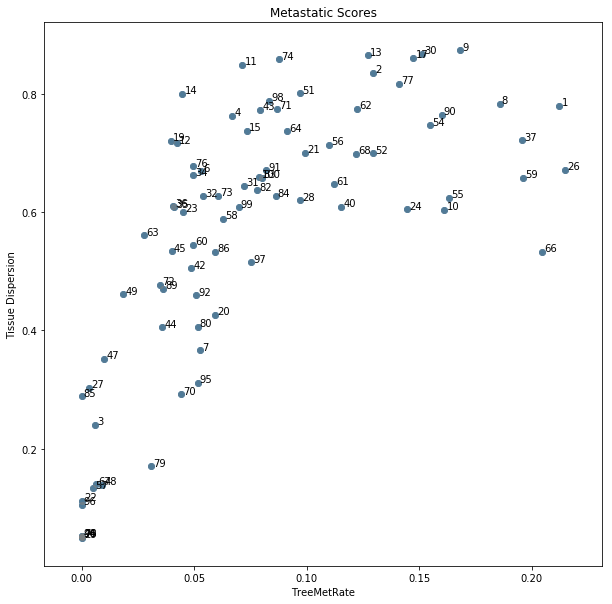

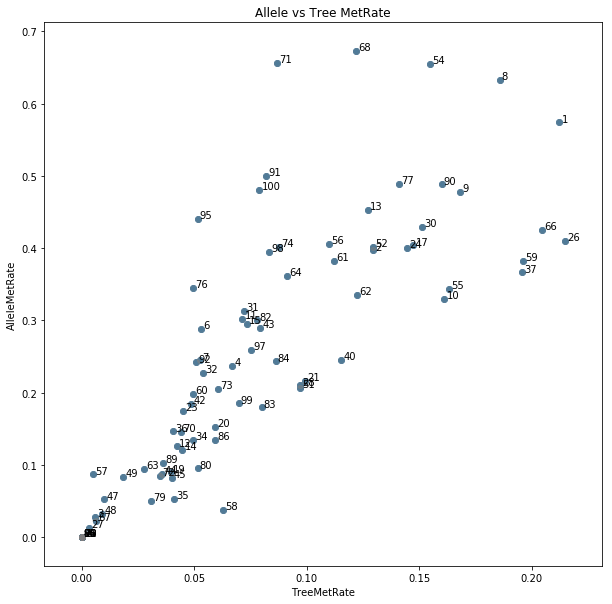

In [593]:
h = plt.figure(figsize = (10, 10))

plt.scatter(evolving_scores, static_scores)
plt.scatter(metscores5k['TreeMetRate'], metscores5k['TissueDispersion'], color = 'gray', alpha = 0.5)
plt.ylabel("Tissue Dispersion")
plt.xlabel("TreeMetRate")
plt.title("Metastatic Scores")

for i, txt in enumerate(labels):
    plt.annotate(txt, (evolving_scores[i]+0.001,  static_scores[i]+0.001))
    
plt.show()

h = plt.figure(figsize = (10, 10))
plt.scatter(evolving_scores, nn_scores)
plt.scatter(metscores5k['TreeMetRate'], metscores5k['AlleleMetRate'],color='gray', alpha=0.5)
plt.ylabel("AlleleMetRate")
plt.xlabel("TreeMetRate")
plt.title("Allele vs Tree MetRate")

for i, txt in enumerate(labels):
    plt.annotate(txt, (evolving_scores[i]+0.001, nn_scores[i]+0.001))
    


In [ ]:
metscores5k['Size'] = 0 
for lg in lg_sizes.keys():
    
    metscores5k.loc[lg, 'Size'] = lg_sizes[lg]

metscores5k = metscores5k[metrates5k['Filtered'] == False]

sns.scatterplot(metscores5k['TreeMetScore'], np.log2(metscores5k['Size']),)
plt.title("Pearson's Rho: " + str(scs.pearsonr(np.log2(metscores5k['Size']), metscores5k['TreeMetScore'])[0]))
plt.ylabel('log2(Clone Size)')
# plt.savefig('size_vs_treemetrate.eps')
plt.show()

## Compare Parsimony Scores for M5k

In [91]:
# compare parsimonies

pars_hyb, pars_nj = [], []
for lg in labels:
    
    hyb, nj = lg_to_hyb[lg], lg_to_nj[lg]
    cm = lg_to_cm[lg]
    nj = Cassiopeia_Tree('neighbor-joining', network=util.fill_in_tree(nj.network, cm))
    
    pars_hyb.append(hyb.score_parsimony(cm))
    pars_nj.append(nj.score_parsimony(cm))


100%|██████████| 187/187 [00:00<00:00, 29657.98it/s]

100%|██████████| 850/850 [00:00<00:00, 34354.36it/s]

100%|██████████| 486/486 [00:00<00:00, 109100.39it/s]

100%|██████████| 1460/1460 [00:00<00:00, 19429.29it/s]

100%|██████████| 1956/1956 [00:00<00:00, 25983.92it/s]

100%|██████████| 259/259 [00:00<00:00, 40837.74it/s]

100%|██████████| 305/305 [00:00<00:00, 44213.13it/s]

100%|██████████| 179/179 [00:00<00:00, 114483.14it/s]

100%|██████████| 77/77 [00:00<00:00, 35924.52it/s]

100%|██████████| 124/124 [00:00<00:00, 11604.05it/s]

100%|██████████| 89/89 [00:00<00:00, 35769.74it/s]

100%|██████████| 145/145 [00:00<00:00, 15143.40it/s]

100%|██████████| 78/78 [00:00<00:00, 27413.75it/s]

100%|██████████| 374/374 [00:00<00:00, 17483.08it/s]

100%|██████████| 315/315 [00:00<00:00, 13913.58it/s]

100%|██████████| 239/239 [00:00<00:00, 24376.00it/s]

100%|██████████| 27661/27661 [00:00<00:00, 44554.01it/s]

100%|██████████| 92/92 [00:00<00:00, 55378.30it/s]

100%|██████████| 154/154 

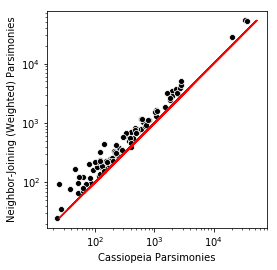

In [106]:
ax = sns.scatterplot(pars_hyb, pars_nj, color='black')
plt.plot(pars_nj, pars_nj, color='red')
plt.loglog()
plt.xlabel("Cassiopeia Parsimonies")
plt.ylabel("Neighbor-Joining (Weighted) Parsimonies")
ax.set_aspect(1)
plt.savefig("cass_vs_nj_pars.eps")
plt.show()

## Compute single-cell Tree MetRates

In [402]:
cells_to_dynmet = {}

for n in tqdm(labels):
    
    if n not in to_drop:

        lg = lg_to_hyb[n].network
        root = [n for n in lg if lg.in_degree(n) == 0][0]

        for n in nx.dfs_postorder_nodes(lg, source=root):

            succ = [k for k in nx.descendants(lg, n)] + [n]
            if len(succ) == 1:
                continue

            subg = lg.subgraph(succ)

            lg.nodes[n]['DynMet'] = met_utils.compute_dynamic_metastasis_score(subg, meta['sampleID'])

        leaves = [n for n in lg if lg.out_degree(n) == 0]
        for l in leaves:

            path = nx.shortest_path(lg, root, l)
            ms = 0
            for p in path:
                if p != l:
                    ms += lg.nodes[p]['DynMet'] 
            ms /= (len(path) - 1)
            cells_to_dynmet[l.name] = ms
        






  0%|          | 0/31 [00:00<?, ?it/s]




  6%|▋         | 2/31 [00:00<00:04,  7.10it/s]




 10%|▉         | 3/31 [00:00<00:03,  7.50it/s]




 16%|█▌        | 5/31 [00:00<00:02,  9.10it/s]




 19%|█▉        | 6/31 [00:00<00:02,  9.13it/s]




 29%|██▉       | 9/31 [00:02<00:06,  3.32it/s]




 42%|████▏     | 13/31 [00:03<00:04,  4.45it/s]




 52%|█████▏    | 16/31 [00:03<00:03,  3.98it/s]




 55%|█████▍    | 17/31 [00:04<00:05,  2.63it/s]




 65%|██████▍   | 20/31 [00:04<00:03,  3.56it/s]




 71%|███████   | 22/31 [00:04<00:01,  4.65it/s]




 77%|███████▋  | 24/31 [00:06<00:02,  2.96it/s]




 84%|████████▍ | 26/31 [00:06<00:01,  3.34it/s]




 90%|█████████ | 28/31 [00:06<00:00,  4.41it/s]




100%|██████████| 31/31 [00:09<00:00,  3.35it/s]


### append to meta

In [404]:
dynmetdf = pd.DataFrame.from_dict(cells_to_dynmet, orient='index')
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)

met_scores = pd.read_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)

meta['TissueDispersion'] = np.nan
meta['TreeMetRate'] = np.nan
meta['scTreeMetRate'] = np.nan

for n in labels:
    if not met_scores.loc[n, 'Filtered']:
        meta.loc[(meta['LineageGroup'] == int(n)), 'TreeMetRate'] = met_scores.loc[n, 'TreeMetScore']
        meta.loc[(meta['LineageGroup'] == int(n)), 'TissueDispersion'] = met_scores.loc[n, 'TissueDispersion']

for k in cells_to_dynmet:
    meta.loc[k, 'scTreeMetRate'] = cells_to_dynmet[k]


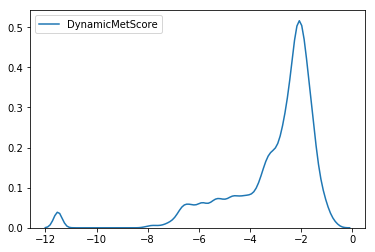

In [11]:
sns.kdeplot(np.log(0.00001 + meta['scTreeMetRate']))
plt.show()

## Compare MetRate distributions between mice

In [ ]:
meta5k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)
meta10k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/10k/10k_meta.txt", sep='\t', index_col = 0)
meta100k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/100k_meta.txt", sep='\t', index_col = 0)
meta30k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/30k/30k_meta.txt", sep='\t', index_col = 0)

In [ ]:
metaf10k = meta10k[-np.isnan(meta10k['scTreeMetRate'])]
metaf100k = meta100k[-np.isnan(meta100k['scTreeMetRate'])]
metaf30k = meta30k[-np.isnan(meta30k['scTreeMetRate'])]

metaf5k = meta5k[-np.isnan(meta5k['DynamicMetScore'])]

sns.kdeplot(metaf5k['DynamicMetScore'], label='5k')
sns.kdeplot(metaf10k['scTreeMetRate'], label = '10k')
sns.kdeplot(metaf100k['scTreeMetRate'], label='100k')
sns.kdeplot(metaf30k['scTreeMetRate'], label='30k')
plt.show()

print(np.max(metaf30k['scTreeMetRate']))

plt.hist(metaf5k['DynamicMetScore'], histtype='step', label='5k', bins=25, range=(0, 0.55), density=True)
plt.hist(metaf10k['scTreeMetRate'], histtype = 'step', label = '10k', bins=25, range=(0, 0.55), density=True)
plt.hist(metaf100k['scTreeMetRate'], histtype = 'step', label = '100k', bins=25, range=(0, 0.55), density=True)
plt.hist(metaf30k['scTreeMetRate'], histtype = 'step', label = '30k', bins=25, range=(0, 0.55), density=True)
plt.legend()
plt.xlabel('scTreeMetRate')
plt.ylabel('Density')
plt.savefig('treemetrate_dist_compare.eps')
plt.show()

print(metaf100k[metaf100k['scTreeMetRate'] > np.percentile(metaf100k['scTreeMetRate'], 75)].shape)
np.percentile(metaf30k['scTreeMetRate'], 5), np.percentile(metaf30k['scTreeMetRate'], 50)